# Vector Space Model

## penjelasan

 **Vector Space Model (VSM)** adalah salah satu metode atau algoritma yang sering digunakan untuk sebuah sistem temu kembali informasi. Algoritma ini merupakan sebuah model yang digunakan untuk mengukur kemiripan atau kesamaan (similarity term) antar suatu dokumen dengan suatu query dengan cara pembobotan term.

Dimateri kali ini kita akan belajar membuat vektor space model dengan menggunakan data pada code sebelumnya dengan catatan hanya menampilkan sebanyak 2 kategori saja dengan jumlah masing 50 data

In [ ]:
!pip install beautifulsoup4 requests

## sebelum di dibuat vektor space model

ini adalah code kita seblumnya untuk penjelasannya bisa di lihat di slide sebelumnya di materi Crowling Web Data.

In [ ]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import display

# Mengambil data dari situs web
url = 'https://www.tempo.co/indeks'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

articles = soup.find_all('article', class_='text-card')

data = []

# Looping melalui artikel dan ekstraksi informasi
article_counter = 1
for article in articles:
    title = article.find('h2', class_='title')
    title_text = title.text.strip() if title else None

    content = article.find('p')
    content_text = content.text.strip() if content else None

    date = article.find('h4', class_='date')
    if date:
        date_text = date.text.strip()
        if "jam lalu" in date_text:
            hours_ago = int(date_text.split(' ')[0])
            publish_time = datetime.now() - timedelta(hours=hours_ago)
            date_text = publish_time.strftime('%d-%m-%Y %H:%M')
    else:
        date_text = None

    link = title.find('a')['href'] if title else None
    category_from_url = link.split('.')[0].replace('https://', '').replace('http://', '') if link else None
    category = category_from_url.capitalize() if category_from_url else None

    data.append({
        'Judul Berita': title_text,
        'Isi Berita': content_text,
        'Tanggal Berita': date_text,
        'Kategori Berita': category
    })

    article_counter += 1

df = pd.DataFrame(data)

df = df.reset_index(drop=True)
df.index += 1

styled_df = df.style.set_table_styles(
    [{'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
     {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '8px'), ('text-align', 'left')]}]
)

# Menampilkan DataFrame dengan gaya border
display(styled_df)


,Judul Berita,Isi Berita,Tanggal Berita,Kategori Berita
1,Telkomsel Perkuat Transformasi Digital melalui Kampanye #PastiAdaSolusi Berani Jadi Lebih,"Telkomsel meluncurkan kampanye baru #PastiAdaSolusi Berani Jadi Lebih yang menekankan komitmen mendukung transformasi digital dengan solusi inovatif berbasis teknologi terkini, membantu pelaku bisnis menghadapi tantangan dan mencapai pertumbuhan berkelanjutan.",6 menit lalu,Bisnis
2,"Ibu Hamil Boleh Naik Pesawat Komersial, Ini Syaratnya di 5 Maskapai",Berikut ketentuan penerbangan dengan pesawat komersial bagi ibu hamil menurut Permenhub dan lima maskapai domestik.,10 menit lalu,Gaya
3,"ICW Soroti Capim KPK Bermasalah yang Lolos, Sebut Pansel Tak Maksimal Gali Rekam Jejak",Apa kata ICW?,12 menit lalu,Nasional
4,Penyebab Penuaan Lebih Tampak di Leher Dibanding Wajah,Leher seolah tak bisa berbohong soal usia meski wajah sudah dirias habis agar tak tampak tua. Berikut penyebab kulit leher cepat kendur.,15 menit lalu,Gaya
5,"Kandidat dari IM57+ Institute Tak Lolos Capim KPK, Praswad: Sejak Awal Kami Tak Percaya Kerja Pansel",Pansel Capim KPK dinilai hanya melakukan kerja administrasi dan bertugas meloloskan capim pilihan istana.,15 menit lalu,Metro
6,"Jumlah Menteri Prabowo Bertambah Jadi 44 Orang, Seperti Apa Isi RUU Kementerian Negara?",Jumlah Menteri Prabowo bertambah jadi 44 orang apabila RUU Kementerian Negara disahkan.,21 menit lalu,Bisnis
7,70 Persen Wisudawan Politeknik Teknologi Nuklir Indonesia Tahun Ini Sudah Ditarik Perusahaan,"Politeknik Teknologi Nuklir Indonesia mewisuda sebanyak 84 lulusan pendidikan sarjana dari tiga program studinya pada Rabu, 11 September 2024.",21 menit lalu,Tekno
8,Rangking FIFA Timnas Indonesia Sempat Naik Usai Bermain Imbang Lawan Australia di Kualifikasi Piala Dunia 2026,"Timnas Indonesia saat ini menempati peringkat ke-133 rangking FIFA, unggul satu strip di atas Malaysia.",22 menit lalu,Bola
9,"Antisipasi Kotak Kosong Menang, KPU Susun Rancangan Jadwal Pilkada Ulang 2025",KPU sedang menyelesaikan proses legal drafting rancangan PKPU tentang Rekapitulasi dan Penetapan Hasil Pilkada.,25 menit lalu,Pemilu
10,"Barang yang Sering Tertinggal di Kamar Hotel, dari Cucian Kotor hingga Jam Mewah","Selain barang-barang yang tertinggal, laporan Hotel Room Innsights juga mengungkapkan layanan kamar yang paling aneh",27 menit lalu,Travel


## menampilkan 2 data kategori

untuk menentukan kategori di sini saya mengambil random dari list sebanyak 2, dan membatasi untuk kategori yang di ambil sebanyak masing masing 50.

bisnis 30
Nasional 49
seleb 14
tekno 21
metro 29
dunia 27
Bola 13

In [ ]:
import random

# Mengambil data dari situs web
url = 'https://www.tempo.co/indeks'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

articles = soup.find_all('article', class_='text-card')

data = []

# Looping melalui artikel dan ekstraksi informasi
for article in articles:
    title = article.find('h2', class_='title')
    title_text = title.text.strip() if title else None

    content = article.find('p')
    content_text = content.text.strip() if content else None

    date = article.find('h4', class_='date')
    if date:
        date_text = date.text.strip()
        if "jam lalu" in date_text:
            hours_ago = int(date_text.split(' ')[0])
            publish_time = datetime.now() - timedelta(hours=hours_ago)
            date_text = publish_time.strftime('%d-%m-%Y %H:%M')
    else:
        date_text = None

    link = title.find('a')['href'] if title else None
    category_from_url = link.split('.')[0].replace('https://', '').replace('http://', '') if link else None
    category = category_from_url.capitalize() if category_from_url else None

    data.append({
        'Judul Berita': title_text,
        'Isi Berita': content_text,
        'Tanggal Berita': date_text,
        'Kategori Berita': category
    })

df = pd.DataFrame(data)

categories = df['Kategori Berita'].unique()

# selected_categories = random.sample(list(categories), 2)
selected_categories = ['Nasional', 'Bisnis']
df_selected = df[df['Kategori Berita'].isin(selected_categories)]
df_final = df_selected.groupby('Kategori Berita').head(50)

df_final = df_final.reset_index(drop=True)
df_final.index += 1

styled_df = df_final.style.set_table_styles(
    [{'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
     {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '8px'), ('text-align', 'left')]}]
)

display(styled_df)


,Judul Berita,Isi Berita,Tanggal Berita,Kategori Berita
1,Telkomsel Perkuat Transformasi Digital melalui Kampanye #PastiAdaSolusi Berani Jadi Lebih,"Telkomsel meluncurkan kampanye baru #PastiAdaSolusi Berani Jadi Lebih yang menekankan komitmen mendukung transformasi digital dengan solusi inovatif berbasis teknologi terkini, membantu pelaku bisnis menghadapi tantangan dan mencapai pertumbuhan berkelanjutan.",6 menit lalu,Bisnis
2,"ICW Soroti Capim KPK Bermasalah yang Lolos, Sebut Pansel Tak Maksimal Gali Rekam Jejak",Apa kata ICW?,12 menit lalu,Nasional
3,"Jumlah Menteri Prabowo Bertambah Jadi 44 Orang, Seperti Apa Isi RUU Kementerian Negara?",Jumlah Menteri Prabowo bertambah jadi 44 orang apabila RUU Kementerian Negara disahkan.,21 menit lalu,Bisnis
4,Pramono Anung Tak Mau Muluk-muluk Bangun Jakarta seperti Dubai,"Bakal calon gubernur dan wakil gubernur Jakarta, Pramono Anung-Rano Karno menghadiri deklarasi relawan di Gedung Joang.",29 menit lalu,Nasional
5,"Pekerja Rumah Tangga Gelar Aksi di 14 Wilayah, Tuntut DPR Sahkan RUU PPRT",Koalisi sipil menuntut DPR segera mengesahkan RUU PPRT.,32 menit lalu,Nasional
6,Lowongan Kerja BUMN dengan Tenggat 30 September 2024,Beberapa anak usaha dari Badan Usaha Milik Negara atau BUMN terus membuka lowongan kerja dengan tenggat yang berbeda,53 menit lalu,Bisnis
7,Jurnalis Tempo Dapat Ucapan Ulang Tahun dan Hadiah dari Paus Fransiskus,"Cerita dari Francisca Christy alias Cica, jurnalis Tempo yang mendapat ucapan selamat ulang tahun langsung dari Paus Fransiskus.",11-09-2024 14:14,Nasional
8,"Soal Temuan Pansus Haji DPR, Begini Respons Menag Yaqut dan KPK",Menteri Agama Yaqut Cholil Qoumas mempersilakan Pansus Haji mengungkapkan temuan-temuannya.,11-09-2024 14:14,Nasional
9,Bagaimana Peluang Heru Budi Jadi Pj Gubernur Jakarta Lagi?,DPRD DKI menilai Heru Budi masih berpeluang untuk menjabat sebagai Pj Gubernur setelah masa jabatannya habis 17 Oktober 2024.,11-09-2024 13:14,Nasional
10,Wamen BUMN Beberkan Alasan Erick Thohir Rombak Direksi Bulog,Kementerian BUMN mengatakan bakal ada perubahan fungsi Bulog ke depan sehingga dilakukan perombakan direksi,11-09-2024 13:14,Bisnis


## setelah dibuat menjadi vektor space model

disini untuk mengubah teks pada kolom "Isi Berita" dalam DataFrame df_final menjadi representasi numerik dengan menggunakan teknik Bag of Words (BoW).Langkah pertama, CountVectorizer dari pustaka scikit-learn diinisialisasi dengan vectorizer = CountVectorizer(). Kemudian, isi berita pada kolom "Isi Berita" yang kosong diisi dengan string kosong (''), dan seluruh teks tersebut diubah menjadi representasi BoW menggunakan vectorizer.fit_transform(). Ini menghasilkan matriks dengan jumlah kata sebagai kolom dan frekuensi kata sebagai nilai.

Matriks ini kemudian diubah menjadi DataFrame baru, bow_df, dengan kolom berupa kata-kata yang ada dalam teks dan indeks yang sesuai dengan df_final. Langkah terakhir adalah menggabungkan DataFrame asli (kecuali kolom "Kategori Berita") dengan DataFrame BoW dan kolom "Kategori Berita" ditempatkan di akhir. Gabungan ini disimpan dalam df_bow menggunakan pd.concat(). Dengan demikian, DataFrame df_bow berisi representasi numerik dari teks asli beserta informasi lainnya dari df_final, kecuali kolom "Kategori Berita" yang ditempatkan di bagian akhir.

In [ ]:
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta
import pandas as pd
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer

# Mengambil data dari situs web
url = 'https://www.tempo.co/indeks'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

articles = soup.find_all('article', class_='text-card')

data = []

article_counter = 1
for article in articles:
    title = article.find('h2', class_='title')
    title_text = title.text.strip() if title else None

    content = article.find('p')
    content_text = content.text.strip() if content else None

    date = article.find('h4', class_='date')
    if date:
        date_text = date.text.strip()
        if "jam lalu" in date_text:
            hours_ago = int(date_text.split(' ')[0])
            publish_time = datetime.now() - timedelta(hours=hours_ago)
            date_text = publish_time.strftime('%d-%m-%Y %H:%M')
    else:
        date_text = None

    link = title.find('a')['href'] if title else None
    category_from_url = link.split('.')[0].replace('https://', '').replace('http://', '') if link else None
    category = category_from_url.capitalize() if category_from_url else None

    data.append({
        'Judul Berita': title_text,
        'Isi Berita': content_text,
        'Tanggal Berita': date_text,
        'Kategori Berita': category
    })

    article_counter += 1


df = pd.DataFrame(data)

# Menghitung frekuensi kemunculan setiap kategori
category_counts = df['Kategori Berita'].value_counts()
top_categories = category_counts.head(2).index
df_top = df[df['Kategori Berita'].isin(top_categories)]
df_final = df_top.groupby('Kategori Berita').head(50)

df_final = df_final.reset_index(drop=True)
df_final.index += 1

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_final['Isi Berita'].fillna(''))
bow_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out(), index=df_final.index)
df_bow = pd.concat([df_final.drop(columns='Kategori Berita'), bow_df, df_final['Kategori Berita']], axis=1)

styled_df_bow = df_bow.style.set_table_styles(
    [{'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
     {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '8px'), ('text-align', 'left')]}]
)

display(styled_df_bow)


Output hidden; open in https://colab.research.google.com to view.

## Mengunduh dan menambahkan stopwords

selanjutnya penabahan code yang digunakan membersihkan teks dengan menghapus stopwords dan melakukan stemming atau mengubah ke text dasar. Pertama, stopwords bahasa Indonesia diunduh dan ditambah dengan angka atau kata-kata khusus. Lalu, stemmer dari Sastrawi digunakan untuk menyederhanakan kata-kata. Fungsi clean_text memproses teks dengan menghilangkan stopwords dan menghasilkan teks yang bersih.

In [ ]:
!pip install nltk sastrawi

## representasi Bag of Words menjadi representasi pembobotan TF-IDF

selanjutnya mengubah code untuk mengonversi teks berita yang sudah dibersihkan menjadi representasi TF-IDF menggunakan TfidfVectorizer dari scikit-learn. Kata-kata umum diabaikan, dan hasil TF-IDF dikonversi menjadi DataFrame. DataFrame ini digabung dengan kolom-kolom baru berisi bobot TF-IDF untuk setiap kata.

In [ ]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from bs4 import BeautifulSoup
import requests
from datetime import datetime, timedelta
from nltk.corpus import stopwords as nltk_stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk

# Download stopwords jika belum terunduh
nltk.download('stopwords')

stopwords = set(nltk_stopwords.words('indonesian'))

additional_stopwords = [
    '00', '000', '10', '16', '17', '20', '2022', '2023', '2024', '2027', '2029', '215',
    '25', '31', '36', '38', '40', '44', '522', '670', '731', '943', '100', '18', '19', '24', '32', '41', '500'
]
stopwords.update([str(i) for i in range(0, 1000)])  # Menghapus semua angka 0-999
stopwords.update([word.lower() for word in additional_stopwords])

# Buat objek stemmer untuk stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Fungsi untuk membersihkan teks, melakukan stemming, menghapus stopwords dan angka
def clean_text(text, stopwords, stemmer):
    # Menghilangkan semua angka dengan regular expression
    text = re.sub(r'\d+', '', text)
    stemmed_text = stemmer.stem(text)
    words = stemmed_text.split()
    cleaned_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(cleaned_words)

# Mengambil halaman web
url = 'https://www.tempo.co/indeks'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Mengambil artikel dari HTML
articles = soup.find_all('article', class_='text-card')

data = []

# Looping melalui artikel dan ekstraksi informasi
for article in articles:
    title = article.find('h2', class_='title')
    title_text = title.text.strip() if title else None

    content = article.find('p')
    content_text = content.text.strip() if content else None

    date = article.find('h4', class_='date')
    if date:
        date_text = date.text.strip()
        if "jam lalu" in date_text:
            hours_ago = int(date_text.split(' ')[0])
            publish_time = datetime.now() - timedelta(hours=hours_ago)
            date_text = publish_time.strftime('%d-%m-%Y %H:%M')
    else:
        date_text = None

    link = title.find('a')['href'] if title else None
    category_from_url = link.split('.')[0].replace('https://', '').replace('http://', '') if link else None
    category = category_from_url.capitalize() if category_from_url else None

    cleaned_content = clean_text(content_text, stopwords, stemmer) if content_text else None

    data.append({
        'Judul Berita': title_text,
        'Isi Berita': cleaned_content,
        'Tanggal Berita': date_text,
        'Kategori Berita': category
    })

# Membuat DataFrame dari data
df = pd.DataFrame(data)

# Memilih kategori berita teratas berdasarkan frekuensi
category_counts = df['Kategori Berita'].value_counts()
top_categories = category_counts.head(2).index
df_top = df[df['Kategori Berita'].isin(top_categories)]
df_final = df_top.groupby('Kategori Berita').head(50)


df_final = df_final.reset_index(drop=True)
df_final.index += 1

df_final['Isi Berita'] = df_final['Isi Berita'].apply(lambda x: clean_text(x, stopwords, stemmer))

# List stopwords untuk TfidfVectorizer
stopwords_list = list(stopwords)
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords_list)
X_tfidf = tfidf_vectorizer.fit_transform(df_final['Isi Berita'].fillna(''))

# Mengonversi hasil TF-IDF menjadi DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df_final.index)
df_tfidf = pd.concat([df_final.drop(columns='Kategori Berita'), tfidf_df, df_final['Kategori Berita']], axis=1)

styled_df_tfidf = df_tfidf.style.set_table_styles(
    [{'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '100%')]},
     {'selector': 'th, td', 'props': [('border', '1px solid black'), ('padding', '8px'), ('text-align', 'left')]}]
)

# Menampilkan DataFrame dengan TF-IDF
display(styled_df_tfidf)


Output hidden; open in https://colab.research.google.com to view.

## Contoh Output

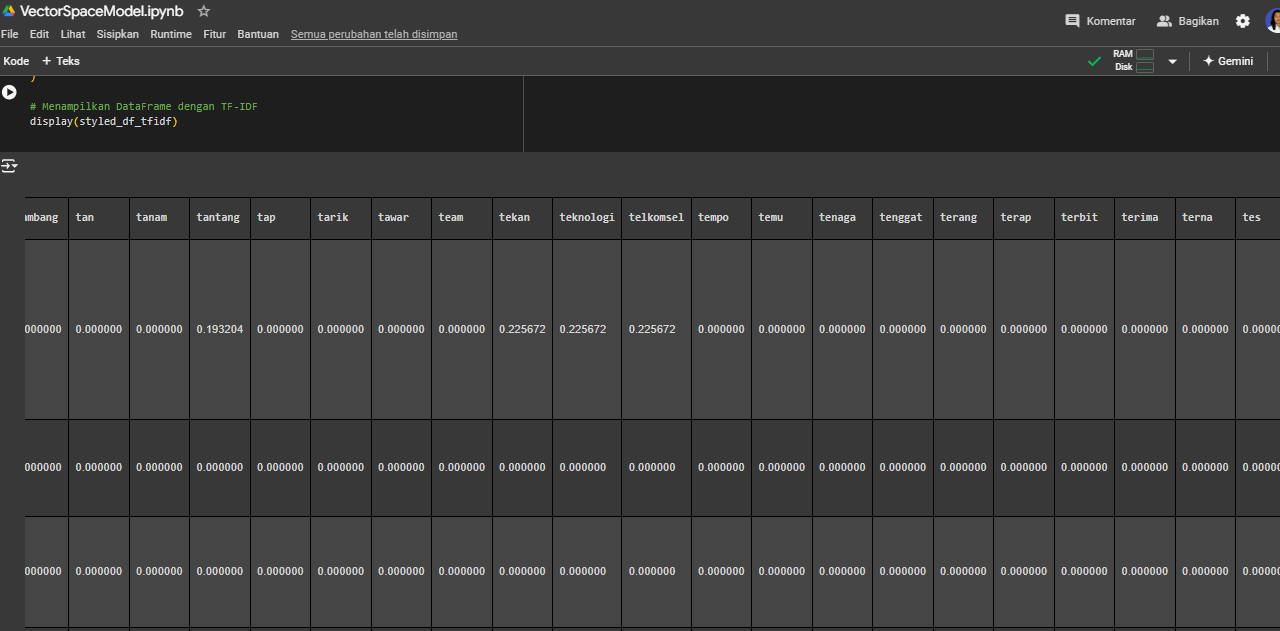